# Projeto de previsão de Querys de SQL Injection

## Importações

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from keras.layers import Dense, Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2025-08-27 17:47:19.495225: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-27 17:47:19.587609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-27 17:47:21.368787: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


# Importação do Dataframe

faça o download pelo link: https://www.kaggle.com/datasets/hrishi1563/sql-injection-dataset-with-sqlfeaturesvalue/data

In [2]:
df = pd.read_csv("SQL_Injection.csv", dtype={"Query": str})
df.describe()

,Label,Sentence Length,AND Count,OR Count,UNION Count,Single Quote Count,Double Quote Count,Constant Value Count,Parentheses Count,Special Characters Total
count,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000
mean,0.368123,68.594845,0.239626,0.127430,0.097222,0.833468,0.256703,2.213914,3.127494,1.447233
std,0.482303,81.068616,0.520416,0.348911,0.330919,1.663833,0.863389,3.529712,6.687481,3.909025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,80.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,1.000000
max,1.000000,5370.000000,6.000000,4.000000,3.000000,13.000000,20.000000,32.000000,44.000000,320.000000


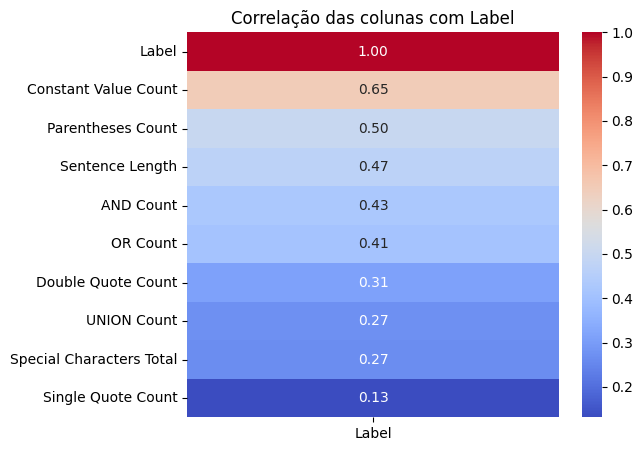

In [3]:
df_corr = df.drop(columns=["Query"]).corr()

label_corr = df_corr[["Label"]].sort_values(by="Label", ascending=False)

plt.figure(figsize=(6, len(label_corr)*0.5))
sns.heatmap(label_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlação das colunas com Label")
plt.show()

In [4]:
y = df["Label"].values

In [5]:
vectorizer = TfidfVectorizer(max_features=700)
x_query = vectorizer.fit_transform(df["Query"]).toarray()

x_tabular = df.drop(columns=["Label", "Query"]).values

x = np.hstack([x_query, x_tabular])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.5, random_state=42)

In [7]:
mlp = Sequential()
mlp.add(Input(shape=(x_train.shape[1],)))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

2025-08-27 17:47:23.209189: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        45,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,665 (194.00 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
mlp.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])

In [10]:
mlp.fit(x_train, y_train, epochs=20, verbose=1)

Epoch 1/20


2025-08-27 17:47:23.842550: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 43841724 exceeds 10% of free system memory.


484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9499 - loss: 0.1887
Epoch 2/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9897 - loss: 0.0443
Epoch 3/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9928 - loss: 0.0300
Epoch 4/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9934 - loss: 0.0282
Epoch 5/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9946 - loss: 0.0220
Epoch 6/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9957 - loss: 0.0188
Epoch 7/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9951 - loss: 0.0192
Epoch 8/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9953 - loss: 0.0202
Epoch 9/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9954 - loss: 0.0187
Epoch 10/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9956 - loss: 0.0188
Epoch 11/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9969 - loss: 0.0131
Epoch 12/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy

In [11]:
_, acuracia = mlp.evaluate(x_test, y_test)
print("Acurácia: %.2f" %(acuracia*100))

  1/484 ━━━━━━━━━━━━━━━━━━━━ 1:05 135ms/step - accuracy: 1.0000 - loss: 0.0034

2025-08-27 17:47:58.503544: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 43844560 exceeds 10% of free system memory.


484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9963 - loss: 0.0157
Acurácia: 99.63


In [12]:
previsoes = mlp.predict(x_test, verbose=1)
rounded_previsoes = [round(x[0]) for x in previsoes]

 81/484 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-08-27 17:48:00.101584: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 43844560 exceeds 10% of free system memory.


484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

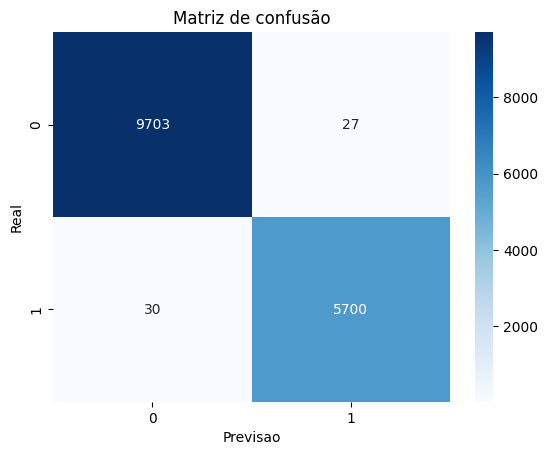

In [14]:
conf_mat = confusion_matrix(y_test, rounded_previsoes)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Previsao')
plt.ylabel('Real')
plt.title('Matriz de confusão')
plt.show()